In [19]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["font.size"] = 14
pd.set_option('display.max_columns', 100)

In [20]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

db = client.database
collection = db.adsE_collection

In [21]:
elements = ['Ag', 'Al', 'Au', 'Cu', 'Pt', 'Pd', 'Ni', 'Rh']
faces = ['100', '111', '110', '211']

dictlis = []

for ele in elements:
    for face in faces:
        dicte = {'element':ele, 'face':face}
        dictlis.append(dicte)

dictlis.append({'element':'CoPt3', 'face':'100'})
dictlis.append({'element':'GaNi', 'face':'110'})

In [22]:
dfall = []
df = []
dfpred = []

for i in range(len(dictlis)):
    try:
        inst = dataset_utilizer(**dictlis[i])
        dfall.append(inst.dfall)
        df.append(inst.df)
        dfpred.append(inst.dfpred)
    except:
        print('Error: {0}'.format(dictlis[i]))

In [23]:
### Exclude coverage > 1.0 ###
for i in range(len(df)):
    df[i] = df[i][df[i]['coverage'] <= 1.0]

### Exclude ads ene > 2.0 ###
for i in range(len(df)):
    df[i] = df[i][df[i]['aveadsE/suratom'] >= -2.0]

In [24]:
# id = -2
# # dfall[id][dfall[id]['numberofads']==1]
# dfall[id]
# #dfall[id][dfall[id]['isvalid']=='yes']

In [25]:
# file = 'Au_110_u2_RPBE_no006_CO_n4_d3_all' + '.traj' 
# iatoms = init_query(file,'local')
# ratoms =query(file, 'local')

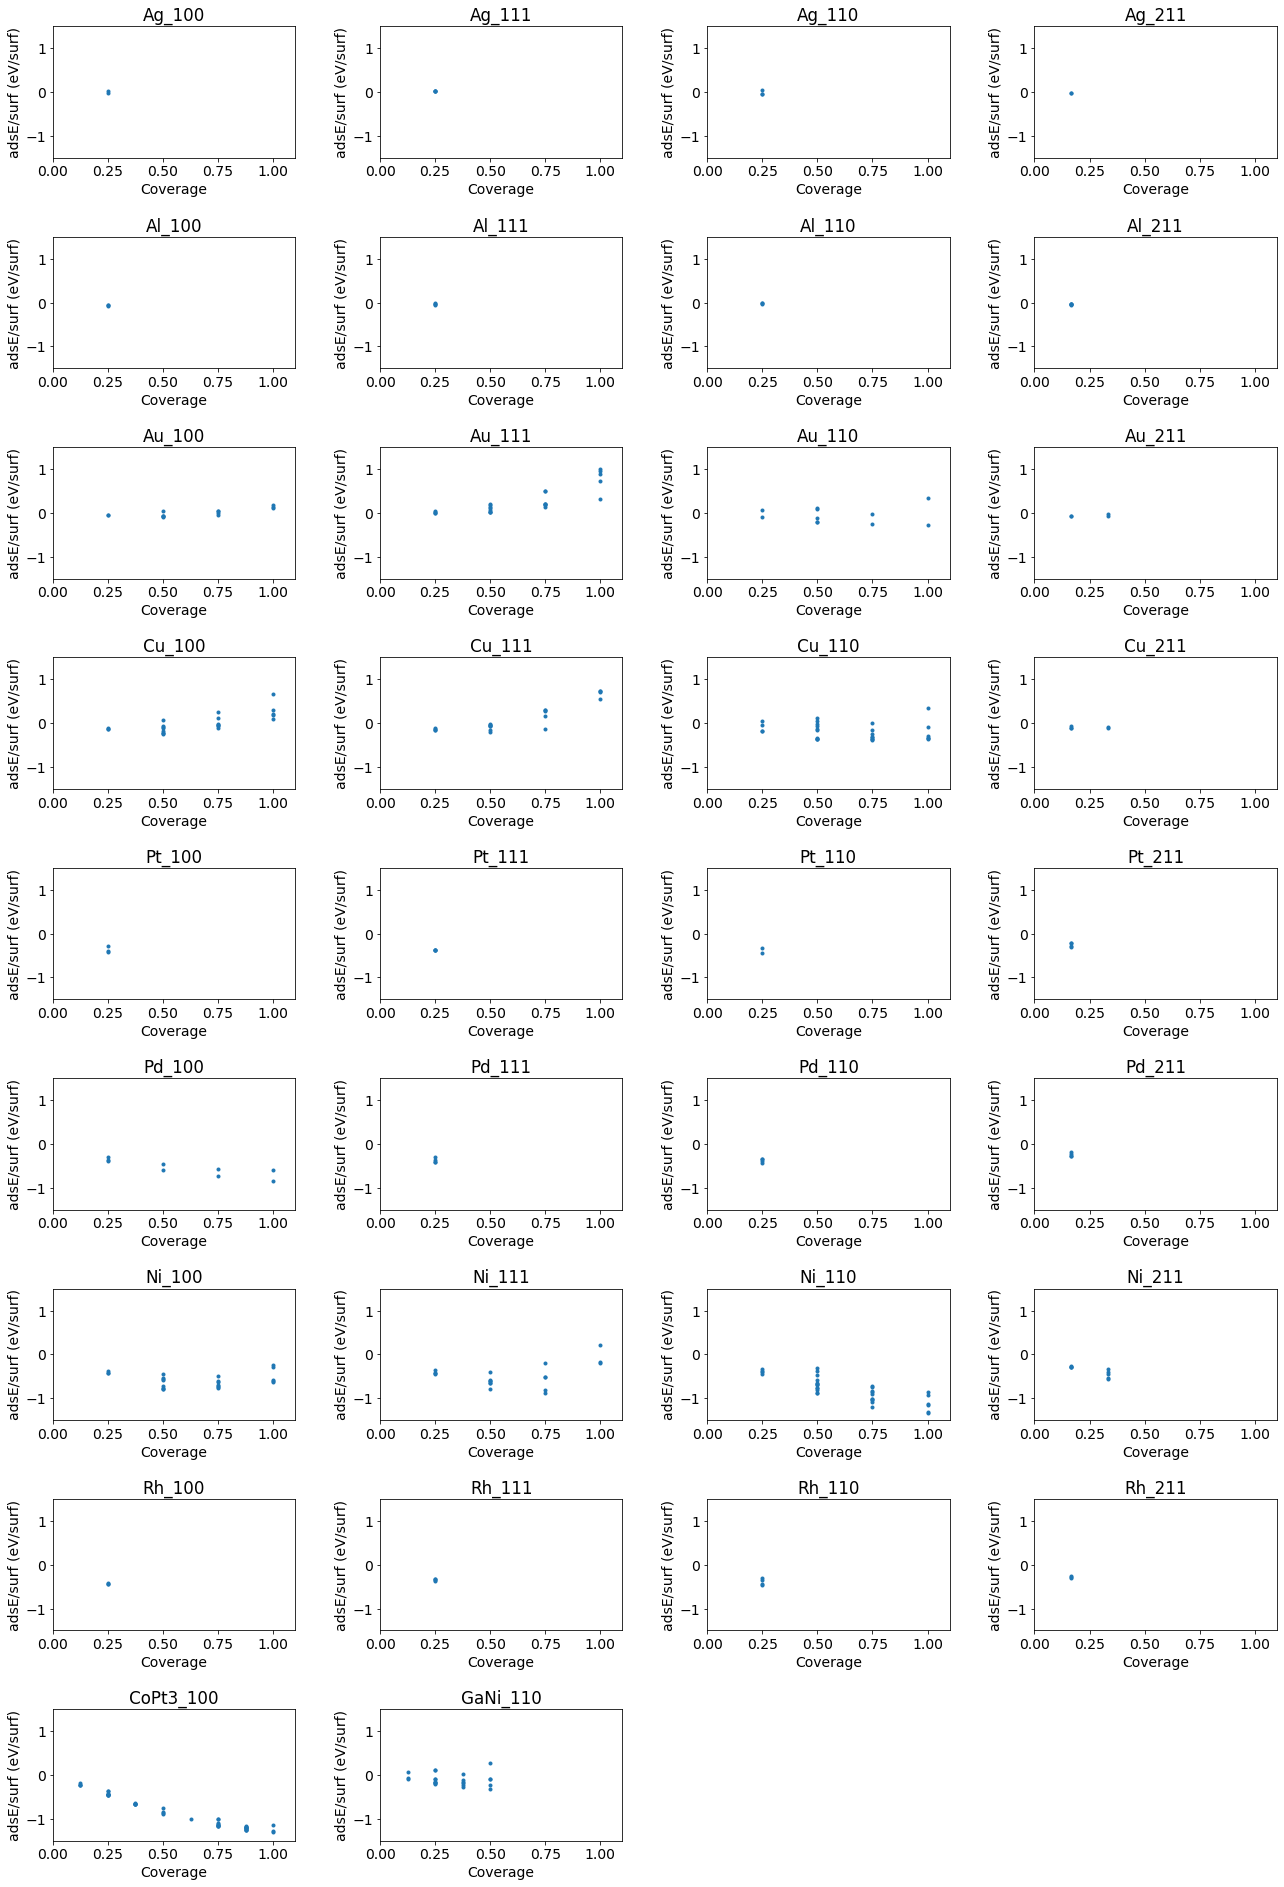

In [26]:
fig = plt.figure(figsize=(20,30))

for i in range(len(df)):
    ax = fig.add_subplot(9, 4, i+1)
    ax.plot(df[i]['coverage'], df[i]['aveadsE/suratom'], '.')
    ax.set_title('{}_{}'.format(df[i]['element'][0], df[i]['face'][0]))
    ax.set_xlabel('Coverage')
    ax.set_ylabel('adsE/surf (eV/surf)')
    ax.set_xlim([0,1.1])
    ax.set_ylim([-1.5,1.5])    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()

In [9]:
covset = []
for i in range(len(df)):
    covset.append(sorted(list(set(df[i]['coverage']))))
covset

[[0.25],
 [0.25],
 [0.25],
 [0.16666666666666666],
 [0.25],
 [0.25],
 [0.25],
 [0.16666666666666666],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.16666666666666666, 0.3333333333333333],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.16666666666666666, 0.3333333333333333],
 [0.25],
 [0.25],
 [0.25],
 [0.16666666666666666],
 [0.25],
 [0.25],
 [0.25],
 [0.16666666666666666],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.16666666666666666],
 [0.25],
 [0.25],
 [0.25],
 [0.16666666666666666],
 [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0],
 [0.125, 0.25, 0.375, 0.5]]

In [10]:
eneset = copy.deepcopy(covset)
for i in range(len(covset)):
    for j in range(len(covset[i])):
        eneset[i][j] = df[i][df[i]['coverage'] == covset[i][j]]['aveadsE/suratom'].min()

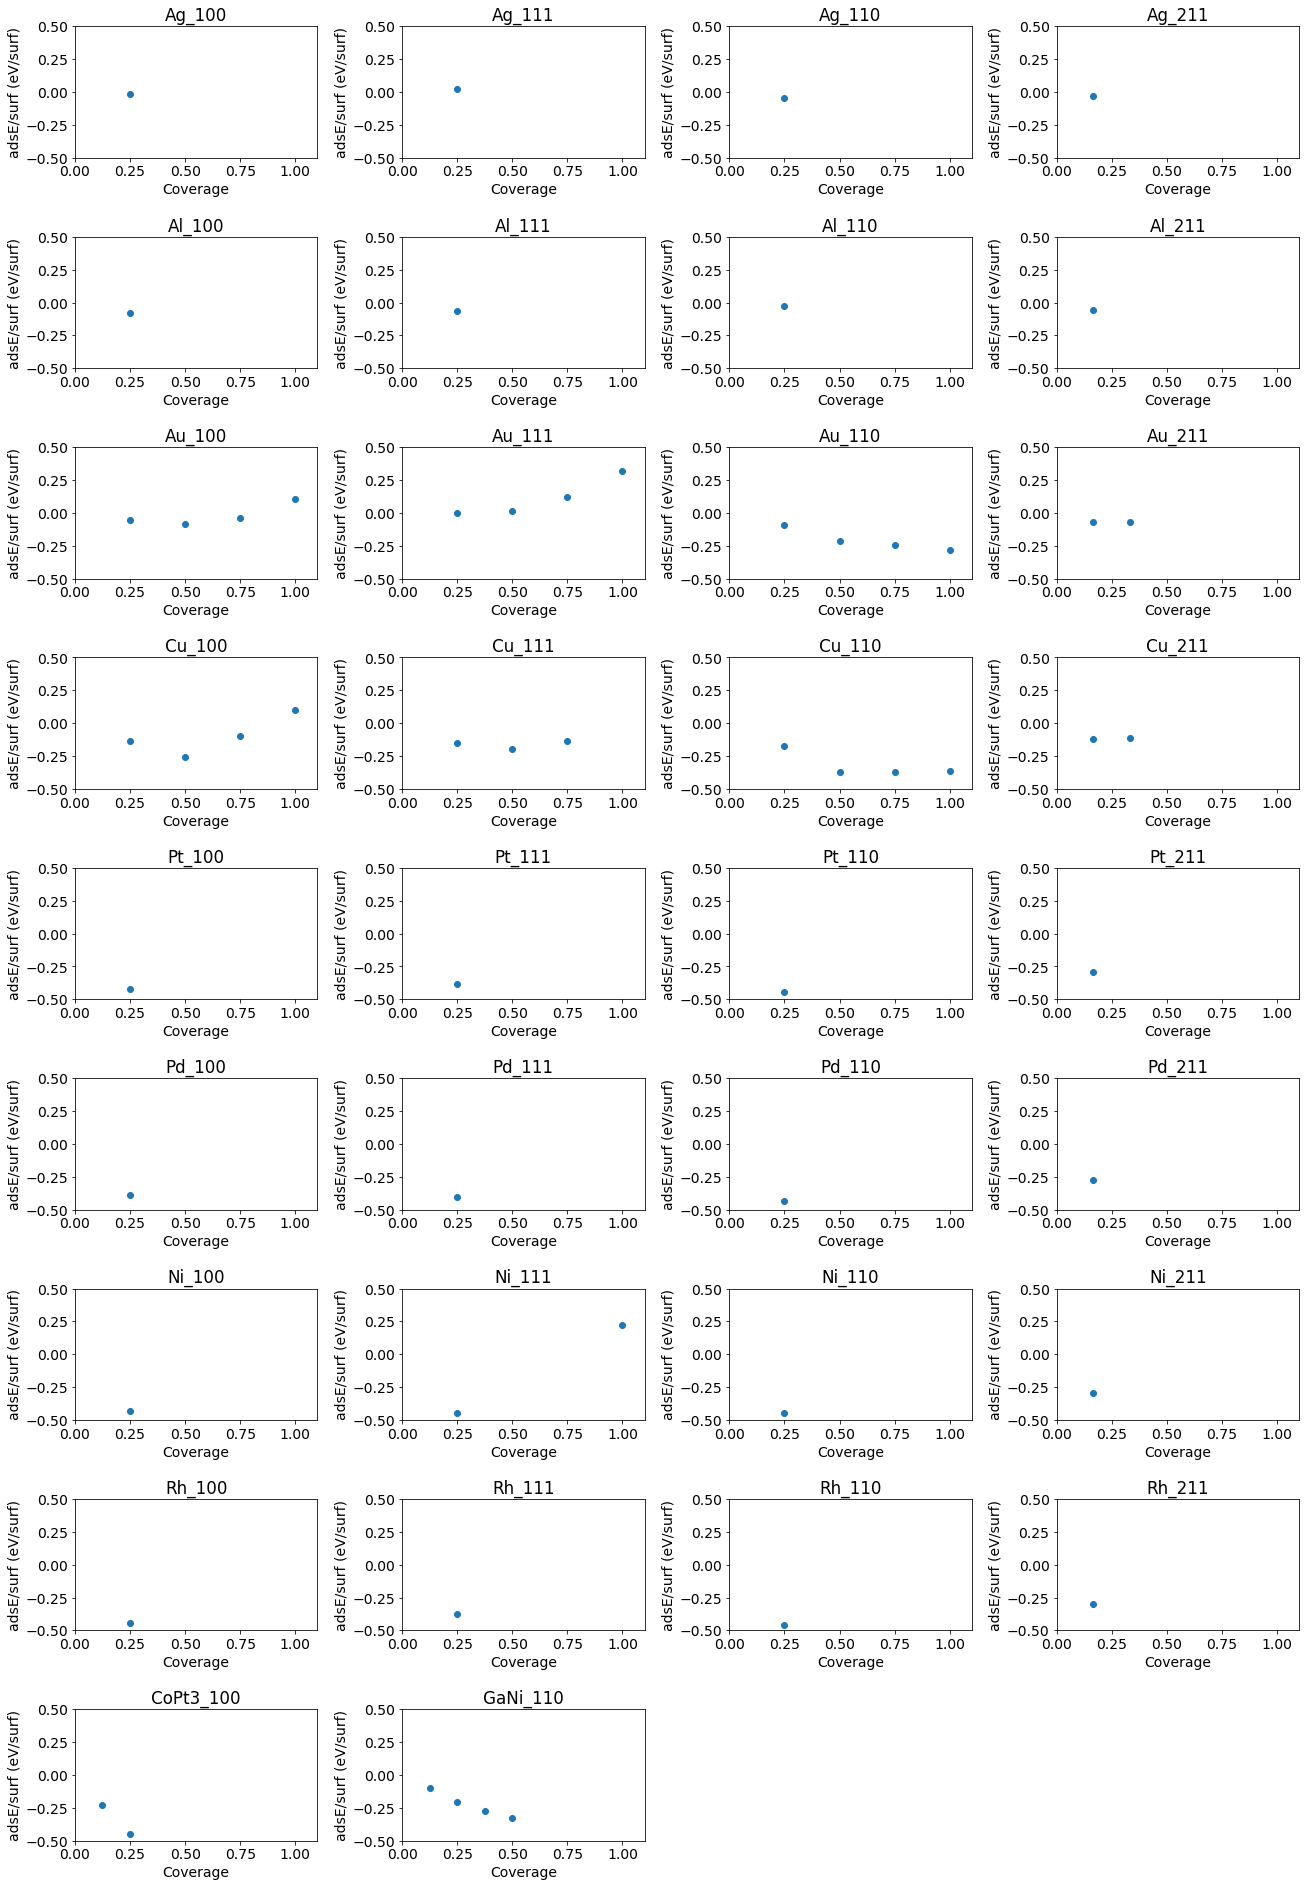

In [12]:
fig = plt.figure(figsize=(20,30))

for i in range(len(df)):
    ax = fig.add_subplot(9, 4, i+1)
    ax.plot(covset[i], eneset[i], 'o')
    ax.set_title('{}_{}'.format(df[i]['element'][0], df[i]['face'][0]))
    ax.set_xlabel('Coverage')
    ax.set_ylabel('adsE/surf (eV/surf)')
    ax.set_xlim([0,1.1])
    ax.set_ylim([-0.5,0.5])    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()

In [23]:
kb = 8.62E-05 # eV/K
T = 298 # K
Pref = 1 # bar

In [24]:
prange = [0.01, 0.1, 1, 10, 100, 1000]
pres = []

for i in range(len(eneset)):
    tmp = []
    for p in prange:
        tmp.append(eneset[i]-kb*T*np.log(p/Pref)*np.array(covset[i]))
    pres.append(tmp)

ValueError: num must be 1 <= num <= 20, not 21

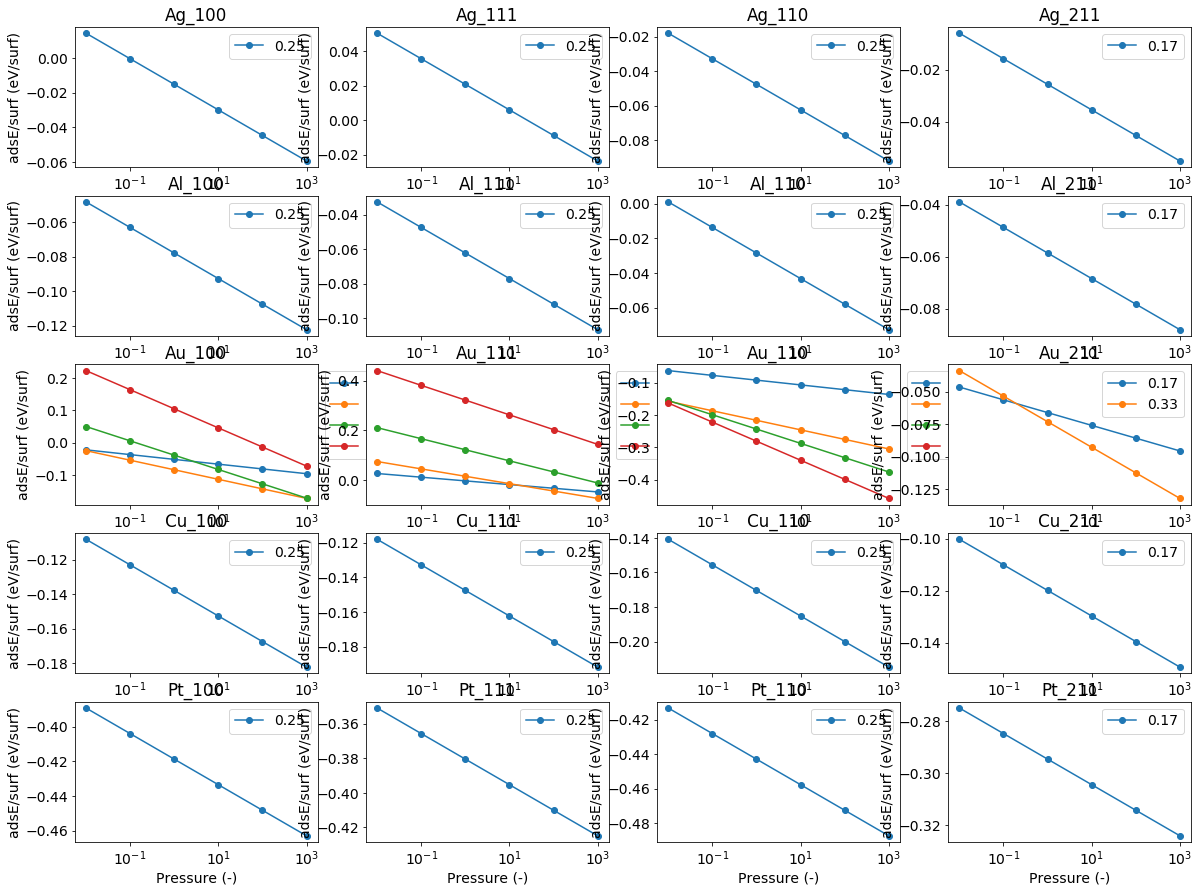

In [97]:
# for i in range(len(pres)):
#     plt.plot(prange, pres[i], 'o-')
#     plt.xscale('log')
#     plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
#     plt.xlabel('Pressure (-)')
#     plt.ylabel('adsorption Energy per surface atom (eV)')
#     plt.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
# #     plt.savefig('{}_{}_pourbaix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
#     plt.show()
    
fig = plt.figure(figsize=(20,15))

for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(prange, pres[i], 'o-')
    plt.xscale('log')
    ax.set_title('{}_{}'.format(df[i]['element'][0], df[i]['face'][0]))
    ax.set_xlabel('Pressure (-)')
    ax.set_ylabel('adsE/surf (eV/surf)')
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 1))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.8, wspace=0.7)
# plt.savefig('')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
Lin = LinearRegression()

In [ ]:
def linearfit(X, y):
    index = 1
    Lin.fit(X[:index+1], y[:index+1])
    y_pred = Lin.predict(X)
    slope = Lin.coef_
    return y_pred, slope

In [ ]:
densityset = []
for i in range(len(covset)):
    densityset.append(covset[i]/df[i][df[i]['unitlength'] ==1]['area'][0])

In [ ]:
def func(X, slope, a2, a3, a4, a5, a6, a7, a8):
    return slope*X + a2*X**2 + a3*X**3 + a4*X**4 + a5*X**5 + a6*X**6 + a7*X**7 + a8*X**8

In [ ]:
def MSE(A):
    a2, a3, a4, a5, a6, a7, a8 = A
    mse = 0
    for i in range(0,6):
        X, y = (list(x) for x in zip(*sorted(zip(densityset[i], eneset[i]))))
        X = np.array(X)
        y = np.array(y)    
        X_ = X.reshape(-1, 1)
        fitres, slope = linearfit(X_, y)

        mse += sum((y - func(X, slope, a2, a3, a4, a5, a6, a7, a8))**2)
    return mse

In [ ]:
from scipy.optimize import minimize
sol = minimize(MSE, [1,1,1,1,1,1,1])
sol.x

In [ ]:
fig = plt.figure(figsize=(20,15))
 
for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    X, y = (list(x) for x in zip(*sorted(zip(densityset[i], eneset[i]))))
    X = np.array(X)
    y = np.array(y)    
    X = X.reshape(-1, 1)
    fitres, slope = linearfit(X, y)

    ax.plot(X, y, 'o')
    ax.plot(X, func(X, slope, *sol.x), '-')
    ax.set_title('{}_{}'.format(df[i]['element'][0], df[i]['face'][0]))
    ax.set_xlabel('density (/A^2)')
    ax.set_ylabel('adsE/sur (eV/surf)')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()